%run feature_engineering.ipynb

In [42]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
import matplotlib as plt

In [43]:
%run feature_engineering.ipynb

In [44]:
df_hospital = df_hospital
df_portobello = df_portobello

In [45]:
y_portobello=df_portobello["AVAILABLE BIKES"]
X_portobello = df_portobello.drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES","TIME"])

In [46]:
ridge_model = Ridge()
ridge_model.fit(X_portobello,y_portobello)
print(ridge_model.feature_names_in_)
print(ridge_model.coef_)


['DAY OF WEEK' 'HOUR' 'MINUTE' '15MIN' '30MIN' '45MIN' '1DAY' '2DAY'
 '3DAY' '1WEEK']
[-0.01014458  0.02790425 -0.00677619  0.9818923  -0.11029948  0.03921774
  0.02063672  0.01113574  0.01300128  0.04442453]


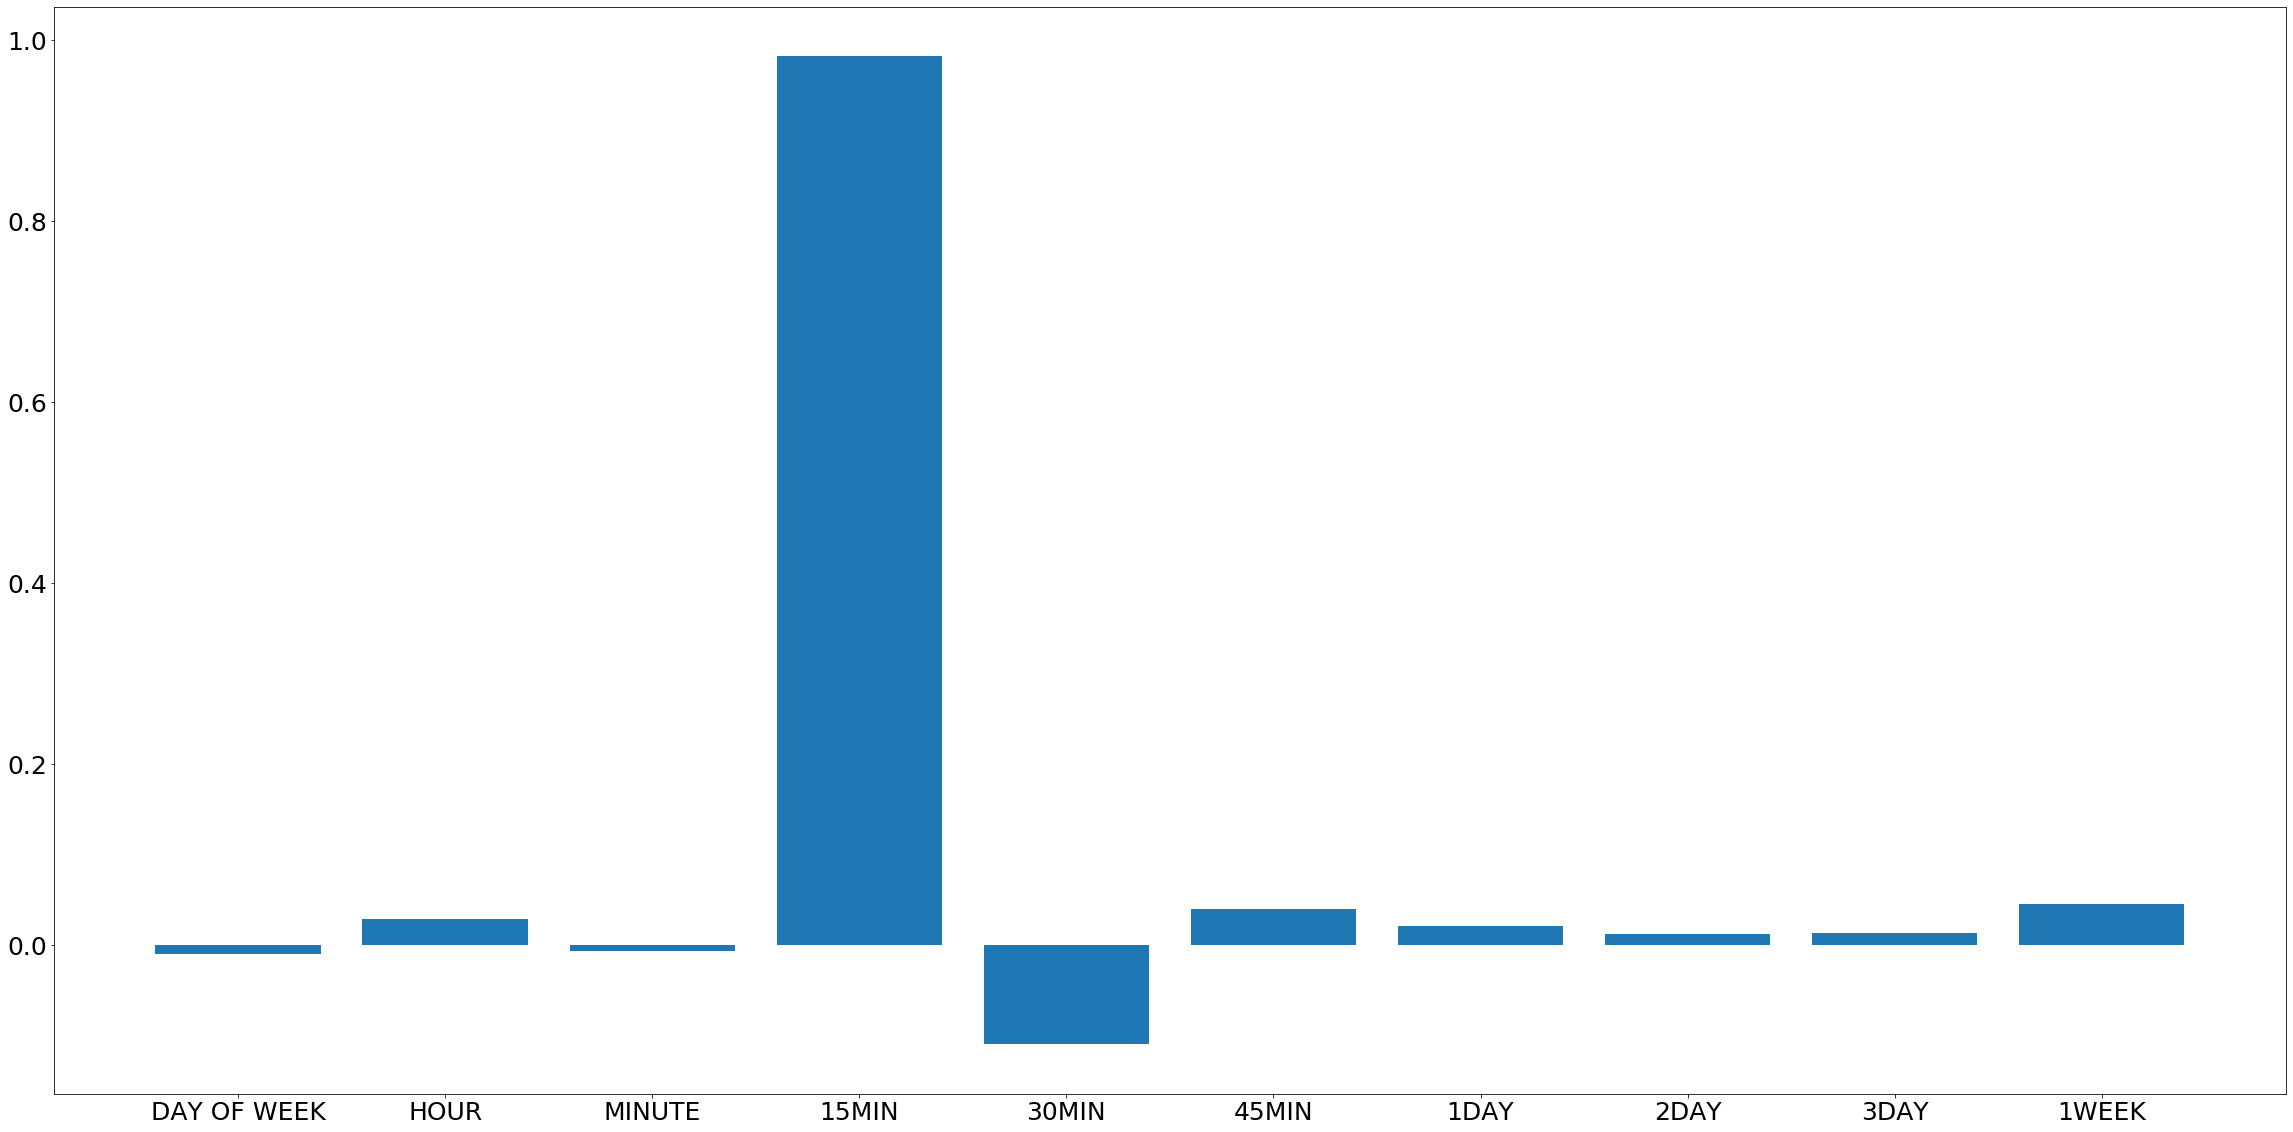

In [52]:

plt.figure(figsize=(40,20))
plt.rc('font',size=25)
plt.bar(ridge_model.feature_names_in_, ridge_model.coef_)
plt.show()